In [41]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# with open("/content/drive/MyDrive/covid/data/new_york_(excludes_nyc).csv", "r", encoding="utf-8") as f:
#     data = f.read()

# data = [row.split(',') for row in  data.split("\n")]

# # value = [int(each[1]) for each in data]
# value = [float(each[2]) for each in data[1:]]

import csv
value = []
with open("cleaned/new_ny.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        value.append(int(i[2]))

value.reverse()

train  = value[:-200]
test = value[-200:]


# 设置序列数据的时间跨度，seq=7, 指使用过去七天的数据来预测明天的数据
# 注意，这并不是说LSTM每次都只利用到7天的历史数据进行预测，而是7天的显式数据+所有已输入的数据产生的隐式信息（只是隐式信息具有离当前预测距离越远，信息量越弱的特点，详情看下行链接）
# https://www.jianshu.com/p/6815da2d413d 关于RNN的长距离依赖问题，看下这个链接，LSTM比RNN在这方面强很多，但问题仍然存在。


seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(train) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

# 对数据进行缩放有利于训练的收敛，但更好的方式是进行归一化处理；在当前应用上，这几种操作对结果不会造成太大影响，可以作为以后的练习。
# 关于归一化的作用，可以参考这个帖子：https://www.cnblogs.com/LBSer/p/4440590.html

train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)


# 测试集构造

t_x = []
t_y = []

for i in range(len(test) - seq):
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [45]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [46]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))
        if test_loss < 20:
          # 保存整个网络
          torch.save(model, 'demo') 
          # 保存网络中的参数, 速度快，占空间少
          torch.save(model.state_dict(),'demo')
          break


epoch:20, loss:6.988563537597656, test_loss: 109.30303955078125
epoch:40, loss:2.529073715209961, test_loss: 85.29417419433594
epoch:60, loss:1.0859766006469727, test_loss: 71.46478271484375
epoch:80, loss:0.6582863926887512, test_loss: 62.26706314086914
epoch:100, loss:0.5658473372459412, test_loss: 57.020992279052734
epoch:120, loss:0.5320268273353577, test_loss: 54.51189422607422
epoch:140, loss:0.517543375492096, test_loss: 52.972938537597656
epoch:160, loss:0.5076161623001099, test_loss: 51.80172348022461
epoch:180, loss:0.49840545654296875, test_loss: 50.83708953857422
epoch:200, loss:0.4887843430042267, test_loss: 49.990440368652344
epoch:220, loss:0.47829970717430115, test_loss: 49.169925689697266
epoch:240, loss:0.4670325815677643, test_loss: 48.31610107421875
epoch:260, loss:0.4545588493347168, test_loss: 47.414852142333984
epoch:280, loss:0.4402579069137573, test_loss: 46.465213775634766
epoch:300, loss:0.42385104298591614, test_loss: 45.453590393066406
epoch:320, loss:0.405

使用正确数据作为输入进行预测

MSE: 24800670.0


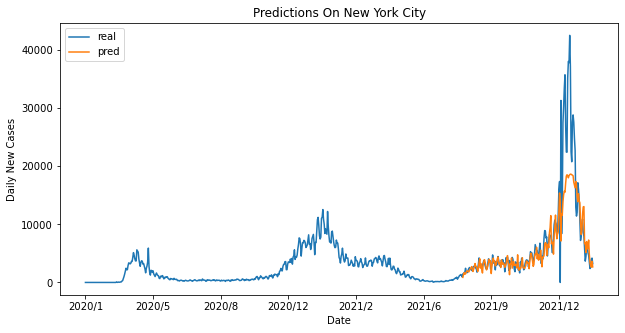

In [53]:
model.eval()

# print(len(value))
# print(len(train))
# print(len(test))

test_pre = list((model(test_x).data.reshape(-1))*1000)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(test_y*1000, test_pre))

plt.figure(figsize=(10,5))

# # 真实数据
# plt.plot(test_y*1000, label="real")

# 真实数据
plt.plot(value, label="real")

test_data = [None]*558 + test_pre
# 预测结果
plt.plot(test_data, label="pred")
plt.title('Predictions On New York City')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '2021/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')

plt.savefig('fig1.png', dpi = 300)


lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)           



使用预测数据作为输入递归预测未来趋势

In [48]:
result = []

result.append(test_x[0][0][0])
result.append(test_x[0][1][0])
result.append(test_x[0][2][0])
result.append(test_x[0][3][0])
result.append(test_x[0][4][0])
result.append(test_x[0][5][0])
result.append(test_x[0][6][0])


print(result)

[tensor(0.7750), tensor(0.9450), tensor(1.1740), tensor(1.2590), tensor(1.3680), tensor(1.2540), tensor(0.9410)]


200
193
[774.9999761581421, 944.9999928474426, 1174.0000247955322, 1258.9999437332153, 1368.0000305175781, 1253.999948501587, 940.9999847412109, 872.326135635376, 899.2438912391663, 1049.3907928466797, 1138.967514038086, 1149.3147611618042, 1080.3864002227783, 966.9167399406433, 907.5353145599365, 923.1070876121521, 972.302496433258, 1001.8597841262817, 996.5272545814514, 961.3053202629089, 914.2717719078064, 883.9102983474731, 877.9974579811096, 883.043110370636, 882.8282356262207, 871.3834881782532, 850.2293229103088, 825.489342212677, 804.2813539505005, 789.0347838401794, 776.8833041191101, 764.0098929405212, 748.6896514892578, 731.0682535171509, 712.3991250991821, 694.2381262779236, 677.4188876152039, 661.7515087127686, 646.7038989067078, 631.9600343704224, 617.4574494361877, 603.3190488815308, 589.7963047027588, 577.1031379699707, 565.3029680252075, 554.3687343597412, 544.2633032798767, 534.9552035331726, 526.4179706573486, 518.6440944671631, 511.6294026374817, 505.3519010543823, 

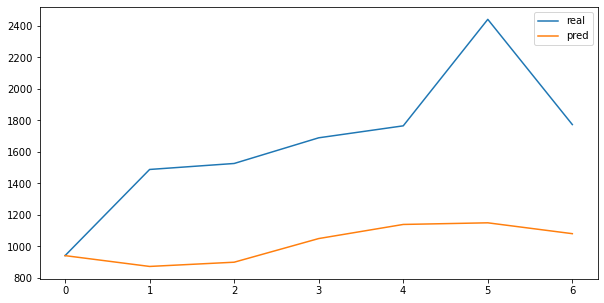

In [49]:
# 预测未来10天的数据，
for i in range(193):
  result.append(model(torch.tensor(result[i:i+7]).reshape(1,7,1)))



print(len(result)) 
print(len(test_y)) 

result = [i.item() * 1000 for i in result]
print(result)

# print("MSE:", mean_squared_error(test_y[0:30]*1000, result[7:]))


plt.figure(figsize=(10,5))

# 真实数据
plt.plot(value[557:564], label="real")

result = [None]*551 + result

print

# 预测结果
plt.plot(result[557:564], label="pred")

# 模型预测的走势
plt.legend(loc='best')

plt.savefig('fig2.png', dpi = 300)

lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)    


真实环境下，预测第11个月的数据：
model = lstm
model([...*6,300]) = y_301
model([...*5, 300, y_301]) = y_302
       ....


预测的越远，效果越差


如果数据有固定的模式，则效果不会变的特别差

黑天鹅




